In [1]:
# Install required packages
import numpy as np
import matplotlib.pyplot as plt
import copy
import networkx as nx
from networkx import grid_2d_graph

# Import pyomo environment and setup gurobi solver
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition
import gurobipy 
solver = pyo.SolverFactory("gurobi_direct")

from main_functions_XOR import *

In [2]:
# Set seed
np.random.seed(42)

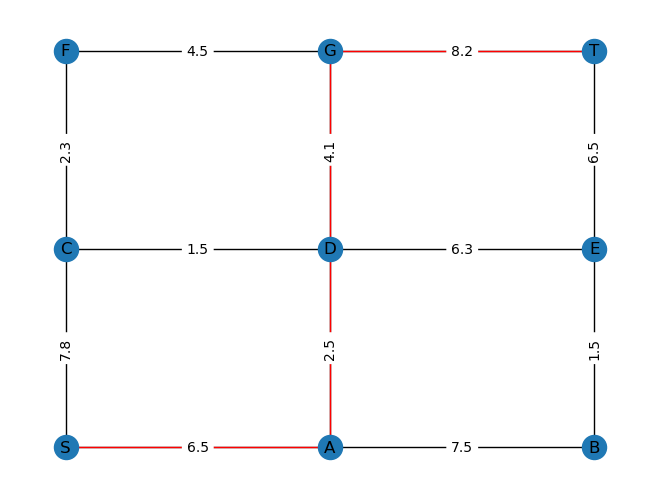

In [4]:
# Create instances for SP problem
node_list = ['S', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
edge_list = [("S", "A"), ("S", "C"), ("A", "B"), ("A", "D"),
             ("C", "D"), ("C", "F"), ("B", "E"), ("D", "E"),
             ("D", "G"), ("F", "G"), ("G", "T"), ("E", "T")]

SP_wgths_dct =  {("S", "A"): {"weight": 6.5}, ("S", "C"): {"weight": 7.8}, 
                 ("A", "B"): {"weight": 7.5}, ("A", "D"): {"weight": 2.5},
                 ("C", "D"): {"weight": 1.5}, ("C", "F"): {"weight": 2.3},
                 ("B", "E"): {"weight": 1.5}, ("D", "E"): {"weight": 6.3},
                 ("D", "G"): {"weight": 4.1}, ("F", "G"): {"weight": 4.5},
                 ("G", "T"): {"weight": 8.2}, ("E", "T"): {"weight": 6.5}}

G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)
nx.set_edge_attributes(G, SP_wgths_dct)

edge_labels = nx.get_edge_attributes(G, "weight")
pos = {"S":(0,0), "A":(1,0),"B":(2,0),"C":(0,1),"D":(1,1),"E":(2,1),"F":(0,2),"G":(1,2), "T":(2,2)}
sp = nx.shortest_path(G, "S", "T", weight='weight')
e_sp = list(zip(sp,sp[1:]))

# Plot instance of the graph
nx.draw(G, pos, with_labels = True)
nx.draw_networkx_edges(G, pos, edgelist=e_sp, edge_color="r")
nx.draw_networkx_edge_labels(G, pos, edge_labels)


# Set explainer variables
features_lbls = list(SP_wgths_dct.keys())
features_inds = [*range(10)]

weight_widths = [0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10]

pos_mdls_dict_prm = {'DecisionTreeRegressor':  {'max_depth': [2, 3, 4],
                                                'min_samples_leaf': [50, 100, 150]},
                    'LinearRegression':        {}
                    }

In [5]:
print('Instance shortest path costs:' , nx.shortest_path_length(G, "S", "T", weight='weight'))
print('Instance shortest path:' ,nx.shortest_path(G, "S", "T", weight='weight'))

dict_values([6.5, 7.8, 7.5, 2.5, 1.5, 1.5, 2.3, 6.3, 4.1, 6.5, 4.5, 8.2])
21.299999999999997
['S', 'A', 'D', 'G', 'T']


In [6]:
# Define function that solves SPP

def shortest_path_solver(vals, output = 'goal', G_org = G, start = 'S', end = 'T'):
    G_loc = copy.deepcopy(G_org)
    SP_wgths_lcl = {}

    for i in range(len(edge_list)):
        SP_wgths_lcl[edge_list[i]] = {}
        SP_wgths_lcl[edge_list[i]]['weight'] = vals[i]

    nx.set_edge_attributes(G_loc, SP_wgths_lcl)

    if output == 'goal':
        return nx.shortest_path_length(G_loc, start, end, weight='weight')

    elif output == 'bounded' or output == 'feasibility':
        return vals.all() > 0
    
    elif output == 'path':
        return nx.shortest_path(G_loc, start, end, weight='weight')
    
    else:
        raise ValueError("Output not supported for model function")

## Parametric optimiztion

In [7]:
# Create a perturbation vecotr

SP_prtb_dct = {("S", "A"): {"weight": 0.5}, ("S", "C"): {"weight": 1.75}, 
                ("A", "B"): {"weight": 0.5},  ("A", "D"): {"weight": 0.5},
                ("C", "D"): {"weight": 0.7},  ("C", "F"): {"weight": 0.25},
                ("B", "E"): {"weight": 0.5},  ("D", "E"): {"weight": 1.25},
                ("D", "G"): {"weight": 1.1},  ("F", "G"): {"weight": 0.5},
                ("G", "T"): {"weight": 1.15}, ("E", "T"): {"weight": 0.5}}

org_vals = np.zeros(len(edge_list))
prt_vals = np.zeros(len(edge_list))
for i in range(len(edge_list)):
    org_vals[i] = SP_wgths_dct[edge_list[i]]['weight']
    prt_vals[i] = SP_prtb_dct[edge_list[i]]['weight']


# Sample 1000 instances, determine target values, and determine proximity to original problem -> weights
# Then, train and test candidate surrogate models
lmb_samples = np.concatenate(([0], np.random.uniform(-1,1,1000)))
val_samples = []
outcome_dict_prm_approx = {}

for lmb in lmb_samples:
    val_samples.append(org_vals+ lmb*prt_vals)

yvalues = get_values_from_samples(val_samples, shortest_path_solver)

for wdth in weight_widths:
    weights_lcl = get_weights_from_samples(lmb_samples, ftr_index_list=[0], width=wdth)
    outcome_dict_prm_approx['Width: '+str(wdth)] = train_test_explanation_models(pos_mdls_dict_prm, lmb_samples, yvalues, weights_lcl, feature_indices=[0], store_all=False)

In [8]:
# Apply origanal optimization model and found surrogates to full parameterspace such that we can plot the outcome

lambda_plot = np.linspace(start = -1.0, stop = 1.0, num=100).reshape(-1, 1)

y_plot_optimal = []
y_plot_DTR = {}
y_plot_LR  = {}

for lmb in lambda_plot:
    y_plot_optimal.append(shortest_path_solver(org_vals+ lmb*prt_vals))

for wdth in weight_widths:
    lcl_dict = outcome_dict_prm_approx['Width: '+str(wdth)]
    if len(lcl_dict.keys()) > 0:
        DTR_model = lcl_dict['DecisionTreeRegressor']['Model']
        y_plot_DTR['Width: '+str(wdth)] = DTR_model.predict(lambda_plot)

        LR_model  = lcl_dict['LinearRegression']['Model']
        y_plot_LR['Width: '+str(wdth)] = LR_model.predict(lambda_plot)

In [9]:
#Subset of proximity parameters which we want to plot
subweights = [0.01, 0.1, 0.5, 1, 5, 10]

In [40]:
#Print best found hyperparameters and errors per model type and proximity parameter
for wdth in subweights:
    print("width_prm:", wdth)
    for key in outcome_dict_prm_approx['Width: '+str(wdth)].keys():
        print('Model type:', key)
        print('Hyperparameters:', outcome_dict_prm_approx['Width: '+str(wdth)][key]['Best hyperparameters'])
        print('wmse:', outcome_dict_prm_approx['Width: '+str(wdth)][key]['Wmse'])
        print('wL1:', outcome_dict_prm_approx['Width: '+str(wdth)][key]['WL1e'])

width_prm: 0.01
Model type: DecisionTreeRegressor
Hyperparameters: {'max_depth': 2, 'min_samples_leaf': 50}
wmse: 0.00040676221064599063
wL1: 0.015041594394524084
Model type: LinearRegression
Hyperparameters: {}
wmse: 1.7766370175891096e-30
wL1: 2.518709456368299e-16
width_prm: 0.1
Model type: DecisionTreeRegressor
Hyperparameters: {'max_depth': 4, 'min_samples_leaf': 100}
wmse: 0.04136542615925028
wL1: 0.17672341619122686
Model type: LinearRegression
Hyperparameters: {}
wmse: 7.699230389341318e-05
wL1: 0.0031262050423977463
width_prm: 0.5
Model type: DecisionTreeRegressor
Hyperparameters: {'max_depth': 4, 'min_samples_leaf': 50}
wmse: 0.057200963679627966
wL1: 0.20918175554567883
Model type: LinearRegression
Hyperparameters: {}
wmse: 0.046026032639434035
wL1: 0.17028383498349095
width_prm: 1
Model type: DecisionTreeRegressor
Hyperparameters: {'max_depth': 4, 'min_samples_leaf': 50}
wmse: 0.053752475268542946
wL1: 0.19577780580311654
Model type: LinearRegression
Hyperparameters: {}
wms

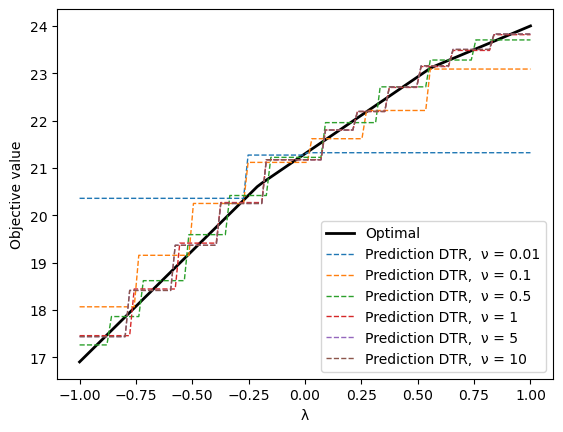

In [11]:
# Plot value found by optimization model, DTR predictions for different proximity parameters
fig = plt.figure()
plt.plot(lambda_plot, y_plot_optimal, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
for wdth in subweights:
    if 'Width: '+str(wdth) in y_plot_DTR.keys():
        plt.plot(lambda_plot, y_plot_DTR['Width: '+str(wdth)], label = 'Prediction DTR,  \u03BD = ' + str(wdth), linestyle = '--', linewidth =1) 

plt.legend() 
plt.xlabel("\u03BB")
plt.ylabel("Objective value") 
plt.show()

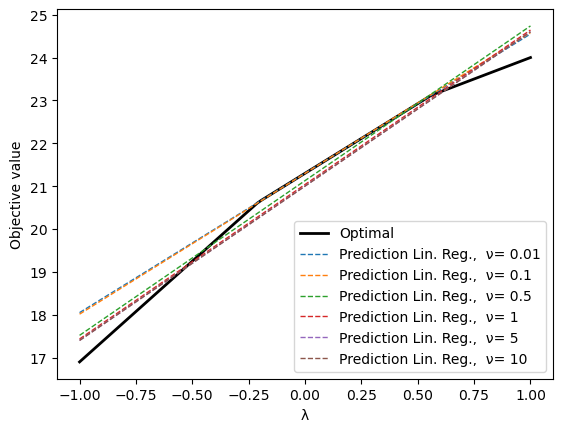

In [12]:
# Plot value found by optimization model, Linear Regression predictions for different proximity parameters
fig = plt.figure()
plt.plot(lambda_plot, y_plot_optimal, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
for wdth in subweights:
    if 'Width: '+str(wdth) in y_plot_LR.keys():
        plt.plot(lambda_plot, y_plot_LR['Width: '+str(wdth)], label = 'Prediction Lin. Reg.,  \u03BD= ' + str(wdth), linestyle = '--', linewidth =1) 

plt.legend() 
plt.xlabel("\u03BB")
plt.ylabel("Objective value") 
plt.show()

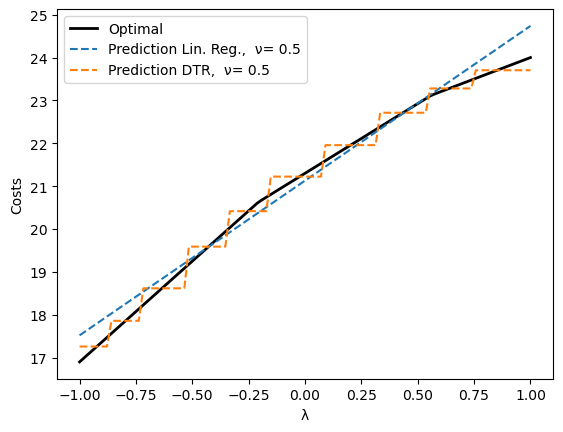

In [13]:
# Plot value found by optimization model, DTR predictions, Linear Regression predictions for one proximity parameter
plt.plot(lambda_plot, y_plot_optimal, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
plt.plot(lambda_plot, y_plot_LR['Width: '+str(0.5)], label = 'Prediction Lin. Reg.,  \u03BD= ' + str(0.5), linestyle = '--', linewidth =1.5) 
plt.plot(lambda_plot, y_plot_DTR['Width: '+str(0.5)], label = 'Prediction DTR,  \u03BD= ' + str(0.5), linestyle = '--', linewidth =1.5) 
plt.legend() 
plt.xlabel("\u03BB")
plt.ylabel("Costs") 
plt.show()

# Structure as a feature

In [14]:
# Define function that finds shortest path by encoding graph structure (edges) as a binary vector in vals 

def shortest_path_structure_solver(vals, G_org = G, output = 'goal', start = 'S', end = 'T'):
    G_loc = copy.deepcopy(G_org)
    edge_list_lcl = list(G_loc.edges())
    edges_to_remove = []
    for i in range(len(vals)):
        if vals[i] == 0:
            edges_to_remove.append(edge_list_lcl[i])
    G_loc.remove_edges_from(edges_to_remove)
    
    if output == 'goal':
        return nx.shortest_path_length(G_loc, start, end, weight='weight')

    elif output in ['feasibility', 'bounded']:
        return nx.has_path(G_loc, start, end)

    else:
        raise ValueError("Output not supported for model function")

In [15]:
# Create variables to conduct experiment for explaining optimal objective value
# of SPP in terms of graph's structure

orig_structre = np.ones(len(edge_list))
features_inds_str = [*range(len(edge_list))]

weight_widths = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10]


pos_mdls_dict_structure = { 'DecisionTreeRegressor':    {'max_depth': [3, 4, 5],
                                                        'min_samples_leaf': [50, 100, 150]},
                            'LinearRegression':         {},
                            'RidgeRegression':          {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]},
                            'LASSORegression':          {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]}
                            }

In [16]:
# Get samples, weights, and target values
samples_str = sample_perturbations_binary(orig_structre, features_inds_str, prob=0.8, model_lcl = shortest_path_structure_solver)
weights_str = []
for wdth in weight_widths:
    weights_str.append(get_weights_from_samples(samples_str, features_inds_str, width=wdth))
yvalues_str = get_values_from_samples(samples_str, shortest_path_structure_solver)
outcome_dict_str = train_test_explanation_models(pos_mdls_dict_structure, samples_str, yvalues_str, weights_str[4], features_inds_str, store_all=False)

In [17]:
#Print errors for surrogate models found
for model_type in list(pos_mdls_dict_structure.keys()):
    Wmse = outcome_dict_str[model_type]['Wmse']
    print(model_type, 'Wmse: '+str(Wmse))

DecisionTreeRegressor Wmse: 0.012599304216797343
LinearRegression Wmse: 0.012743291886169083
RidgeRegression Wmse: 0.012741460255608992
LASSORegression Wmse: 0.012461473339782873


<Figure size 640x480 with 0 Axes>

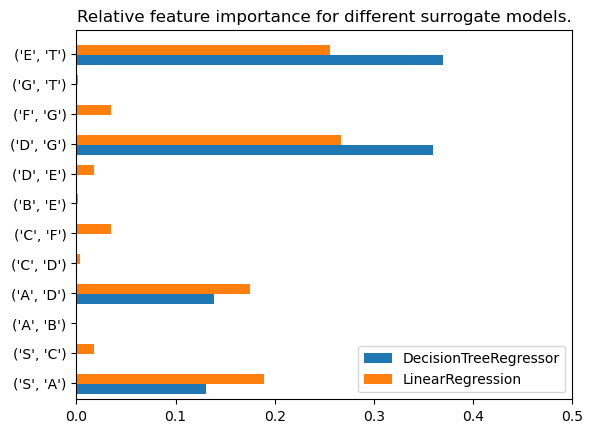

In [42]:
# Plot relative feature importance of surrogate models
surrogate_plots = ['DecisionTreeRegressor', 'LinearRegression']

ind = np.arange(len(edge_list))
width = 1/(len(surrogate_plots)+1)

fig = plt.figure()
fig, ax = plt.subplots()
for i in range(len(surrogate_plots)):
    ftr_imp = outcome_dict_str[surrogate_plots[i]]['Best model feature importance']
    ax.barh(ind +i* width, ftr_imp, width, label=surrogate_plots[i])

ax.set(yticks=ind +0.2, yticklabels=edge_list, ylim=[2*width - 1, len(edge_list)])
plt.title('Relative feature importance for different surrogate models.')
plt.xlim(0,0.5)
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

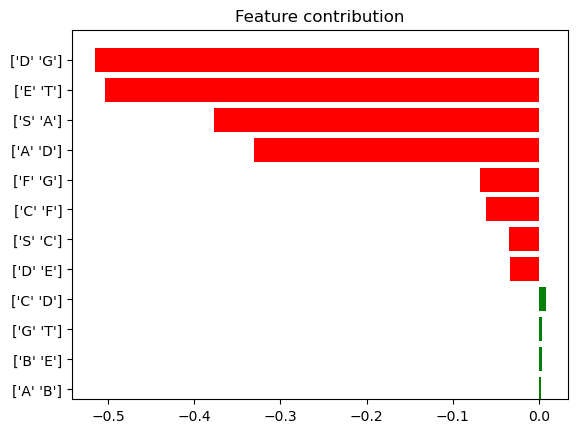

In [19]:
#print tornado plot, feature contribution, for linear regression surrogate
ind = np.arange(len(features_inds_str))

for i in ['LinearRegression']:
    fig = plt.figure()
    fig, ax = plt.subplots()
    trndo = np.multiply(outcome_dict_str[i]['Best model coefficients'], [orig_structre[i] for i in features_inds_str])
    trndo_srt = sorted(trndo, key=abs)
    profit_color = [('green' if t > 0 else 'red') for t in trndo_srt]
    idx = np.argsort(np.abs(trndo))
    features_lbls_srt = (np.array(edge_list)[idx])
    ax.barh(features_inds_str, trndo_srt, color = profit_color)
    ax.set(yticks=ind, yticklabels=features_lbls_srt, ylim=[2*width - 1, len(features_inds_str)])
    plt.title('Feature contribution')
    plt.show()

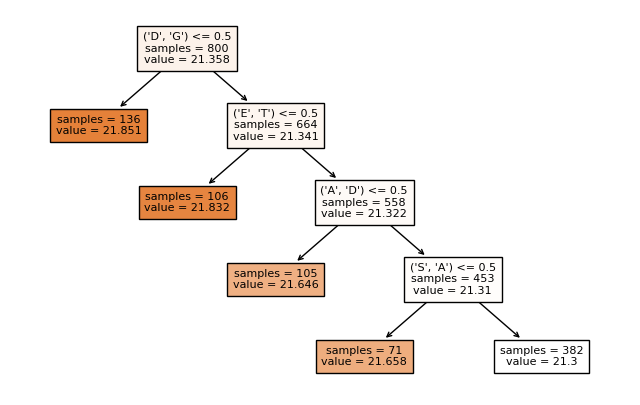

In [20]:
#Plot tree for DTR surrogate
plt.figure(figsize=(8,5))
plot_tree(outcome_dict_str['DecisionTreeRegressor']['Model'], feature_names = edge_list, fontsize=8, impurity=False, filled=True)
plt.show()

# Overall cost sampling

In [21]:
# Create variables to conduct experiment for explaining optimal objective value
# of SPP in terms of edge's costs
orig_cst = org_vals
features_inds_cst = [*range(len(org_vals))]

weight_widths = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10]


pos_mdls_dict_cst = {'DecisionTreeRegressor':   {'max_depth': [3, 4, 5],
                                                'min_samples_leaf': [50, 100, 150]},
                    'LinearRegression':         {},
                    'RidgeRegression':          {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]},
                    'LASSORegression':          {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]}
                    }

In [22]:
# Get samples, weights, and target values
samples_cst = sample_perturbations_normal(orig_cst, features_inds_cst, model_lcl = shortest_path_solver)
weights_cst = []
for wdth in weight_widths:
    weights_cst.append(get_weights_from_samples(samples_cst, features_inds_cst, width=wdth))
yvalues_cst = get_values_from_samples(samples_cst, shortest_path_solver)
outcome_dict_cst = train_test_explanation_models(pos_mdls_dict_cst, samples_cst, yvalues_cst, weights_cst[5], features_inds_cst, store_all=False)

In [23]:
#Print errors for surrogate models found
for model_type in list(pos_mdls_dict_cst.keys()):
    Wmse = outcome_dict_cst[model_type]['Wmse']
    print(model_type, 'Wmse: '+str(Wmse))

DecisionTreeRegressor Wmse: 1.0591645034867574
LinearRegression Wmse: 0.3884875439183176
RidgeRegression Wmse: 0.38847055055458546
LASSORegression Wmse: 0.38885269438823966


<Figure size 640x480 with 0 Axes>

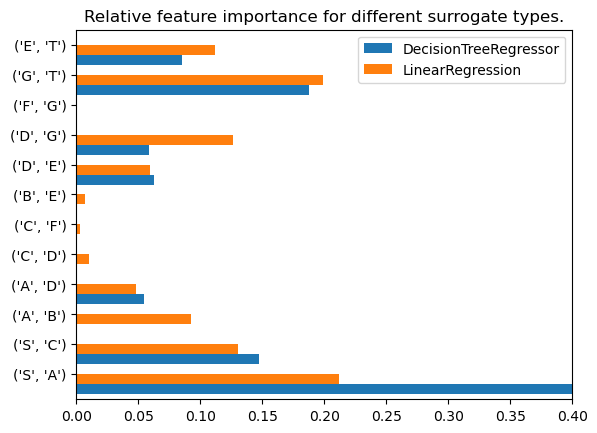

In [24]:
# Plot relative feature importance of surrogate models
surrogate_plots = ['DecisionTreeRegressor', 'LinearRegression']

ind = np.arange(len(edge_list))
width = 1/(len(surrogate_plots)+1)

fig = plt.figure()
fig, ax = plt.subplots()
for i in range(len(surrogate_plots)):
    ftr_imp = outcome_dict_cst[surrogate_plots[i]]['Best model feature importance']
    ax.barh(ind +i* width, ftr_imp, width, label=surrogate_plots[i])

ax.set(yticks=ind + 0.5, yticklabels=edge_list, ylim=[2*width - 1, len(edge_list)])
plt.title('Relative feature importance for different surrogate types.')
plt.xlim(0,0.4)
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

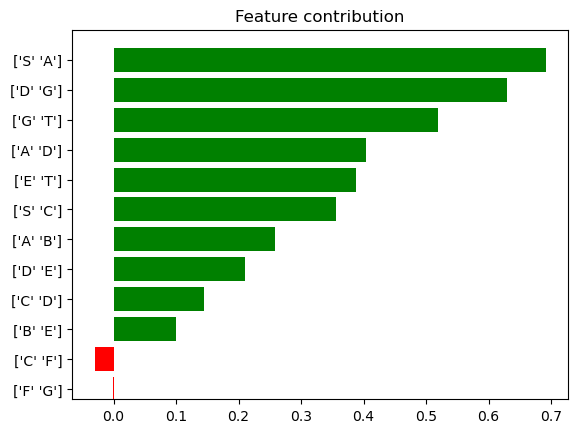

In [25]:
#print tornado plot, feature contribution, for linear regression surrogate
ind = np.arange(len(features_inds_cst))

for i in ['LinearRegression']:
    fig = plt.figure()
    fig, ax = plt.subplots()
    trndo = np.multiply(outcome_dict_cst[i]['Best model coefficients'], [orig_structre[i] for i in features_inds_cst])
    trndo_srt = sorted(trndo, key=abs)
    profit_color = [('green' if t > 0 else 'red') for t in trndo_srt]
    idx = np.argsort(np.abs(trndo))
    features_lbls_srt = (np.array(edge_list)[idx])
    ax.barh(features_inds_cst, trndo_srt, color = profit_color)
    ax.set(yticks=ind, yticklabels=features_lbls_srt, ylim=[2*width - 1, len(features_inds_cst)])
    plt.title('Feature contribution')
    plt.show()

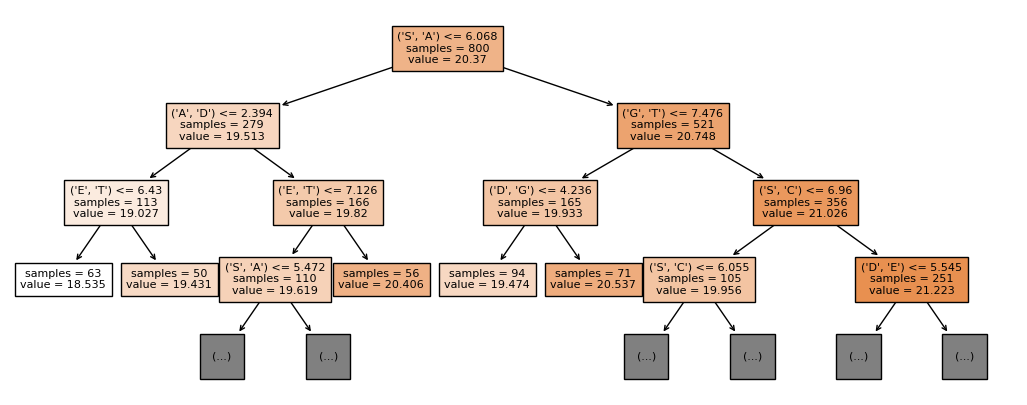

In [48]:
#Plot tree for DTR surrogate
plt.figure(figsize=(13,5))
plot_tree(outcome_dict_cst['DecisionTreeRegressor']['Model'], feature_names = edge_list, fontsize=8, impurity=False, filled=True, max_depth=3)
plt.show()

# Larger experiment
Explaining optimal value in terms of structure

In [54]:
# Set instances and features and dict of potential surrogate models

all_instances = {}

for i in range(15):
    dims = np.random.randint(4,9,size=2)
    nr_edges = int(dims[0]*(dims[1]-1) + dims[1]*(dims[0]-1))
    edg_wt_dct = {}
    
    all_instances['Instance '+str(i+1)] = {}
    all_instances['Instance '+str(i+1)]['Graph'] = grid_2d_graph(n=dims[0], m=dims[1])
    all_instances['Instance '+str(i+1)]['Start'] = (0, 0)
    all_instances['Instance '+str(i+1)]['End'] = (dims[1]-1, dims[0]-1)
    all_instances['Instance '+str(i+1)]['Features'] = [*range(nr_edges)] 
    all_instances['Instance '+str(i+1)]['Orig_structure_coded'] = np.ones(nr_edges)
    for edge in all_instances['Instance '+str(i+1)]['Graph'].edges():
        edg_wt_dct[edge] = {}
        edg_wt_dct[edge]['weight'] = np.random.normal(10, 1)
    nx.set_edge_attributes(all_instances['Instance '+str(i+1)]['Graph'], values=edg_wt_dct)
        
    edg_wt_dct = {}
    all_instances['Instance '+str(i+15)] = {}
    all_instances['Instance '+str(i+15)]['Graph'] = grid_2d_graph(n=dims[0], m=dims[1])
    all_instances['Instance '+str(i+15)]['Start'] = (0, 0)
    all_instances['Instance '+str(i+15)]['End'] = (dims[1]-1, dims[0]-1)
    all_instances['Instance '+str(i+15)]['Features'] = [*range(nr_edges)]
    all_instances['Instance '+str(i+15)]['Orig_structure_coded'] = np.ones(nr_edges)
    for edge in all_instances['Instance '+str(i+1)]['Graph'].edges():
        edg_wt_dct[edge] = {}
        edg_wt_dct[edge]['weight'] = np.random.uniform(1, 10)
    nx.set_edge_attributes(all_instances['Instance '+str(i+15)]['Graph'], values=edg_wt_dct) 

pos_mdls_dict = {'DecisionTreeRegressor':  {'max_depth': [3, 4, 5],
                                            'min_samples_leaf': [50, 100, 150]},
                'LinearRegression':        {},
                'RidgeRegression':         {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
                'LASSORegression':         {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
                }

In [55]:
# Find best surrogate models for each instance

for key in all_instances.keys():
    all_instances[key]['Explainers'] = {}
    hyperprm_loc = {'G_org':all_instances[key]['Graph'], 'start': all_instances[key]['Start'], 'end': all_instances[key]['End']}
    samples = sample_perturbations_binary(all_instances[key]['Orig_structure_coded'], all_instances[key]['Features'], model_lcl = shortest_path_structure_solver, hyperprm=hyperprm_loc)
    yvalues = get_values_from_samples(samples, shortest_path_structure_solver, hyperprm=hyperprm_loc)

    for wdth in weight_widths[3:]:
        weights_lcl = get_weights_from_samples(samples,  all_instances[key]['Features'], width=wdth)
        all_instances[key]['Explainers']['Weight width '+ str(wdth)] = train_test_explanation_models(pos_mdls_dict, samples, yvalues, weights_lcl, all_instances[key]['Features'], store_all=True)

Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many w

c:\Users\DOTTO1\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e-03, tolerance: 1.868e-03
  model = cd_fast.enet_coordinate_descent(


Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many w

In [59]:
#Create dataframe with average error over 30 instances per surrogate model and hyperparameter set
df = pd.DataFrame.from_dict({(i,j,k,l): all_instances[i]['Explainers'][j][k][l]
                            for i in all_instances.keys() 
                            for j in all_instances[i]['Explainers'].keys()
                            for k in all_instances[i]['Explainers'][j].keys()
                            for l in all_instances[i]['Explainers'][j][k].keys()},
                            orient='index')

df.index.names = ['Instances', 'Weight width', 'Model type', 'Hyperparameters']
df = df.reset_index()
df['Weight width nr'] = df['Weight width'].str.split().str[-1].astype('float')

df_ovrvw = df.groupby(['Model type', 'Hyperparameters', 'Weight width nr'])[['Wmse', 'mse', 'WL1e', 'L1e', 'R2']].mean()
df_ovrvw.to_clipboard()
display(df_ovrvw)

Wmse  \
Model type            Hyperparameters                           Weight width nr              
DecisionTreeRegressor {'max_depth': 3, 'min_samples_leaf': 100} 0.5               8.986750   
                                                                1.0              12.596524   
                                                                1.5              20.525450   
                                                                2.0              24.810102   
                                                                5.0              30.581134   
...                                                                                    ...   
RidgeRegression       {'alpha': 1}                              1.0               9.338649   
                                                                1.5              14.020869   
                                                                2.0              17.463672   
                                                                5.0              22.321948   
                                                                10.0             23.132332   

                                                                                       mse  \
Model type            Hyperparameters                           Weight width nr              
DecisionTreeRegressor {'max_depth': 3, 'min_samples_leaf': 100} 0.5              56.765837   
                                                                1.0              36.303550   
                                                                1.5              32.989332   
                                                                2.0              32.281270   
                                                                5.0              31.856755   
...                                                                                    ...   
RidgeRegression       {'alpha': 1}                              1.0              28.305681   
                                                                1.5              23.376102   
                                                                2.0              23.140330   
                                                                5.0              23.316671   
                                                                10.0             23.384387   

                                                                                     WL1e  \
Model type            Hyperparameters                           Weight width nr             
DecisionTreeRegressor {'max_depth': 3, 'min_samples_leaf': 100} 0.5              1.455447   
                                                                1.0              2.236920   
                                                                1.5              2.829539   
                                                                2.0              3.118021   
                                                                5.0              3.479200   
...                                                                                   ...   
RidgeRegression       {'alpha': 1}                              1.0              1.846009   
                                                                1.5              2.228838   
                                                                2.0              2.540848   
                                                                5.0              2.938924   
                                                                10.0             3.001367   

                                                                                      L1e  \
Model type            Hyperparameters                           Weight width nr             
DecisionTreeRegressor {'max_depth': 3, 'min_samples_leaf': 100} 0.5              4.400173   
                                                                1.0              3.393196   
                                                          

Text(0, 0.5, 'wmse')

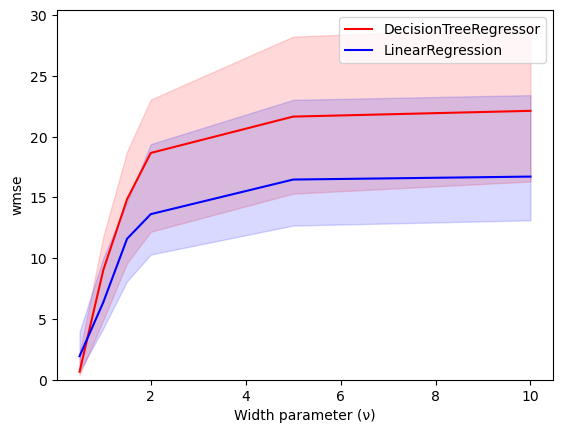

In [49]:
# Plot confidence intervals of specific models over different proximity parameters
plt_types  = ['DecisionTreeRegressor', 
    'LinearRegression'#,'RidgeRegression','LASSORegression'
    ]

df_sub = df[df['Hyperparameters'].isin([str({'max_depth': 5, 'min_samples_leaf': 50}), str({'alpha': 0.0001}), str({})])]
df_sub_ovrvw = df_sub.groupby(['Weight width nr', 'Model type', 'Hyperparameters']).agg({'Wmse': [('Q1', lambda x: np.quantile(x, 0.25)),
                                                                                               ('Q2', lambda x: np.quantile(x, 0.5)),
                                                                                               ('Q3', lambda x: np.quantile(x, 0.75))],
                                                                                        'mse': [('Q1', lambda x: np.quantile(x, 0.25)),
                                                                                               ('Q2', lambda x: np.quantile(x, 0.5)),
                                                                                               ('Q3', lambda x: np.quantile(x, 0.75))]})
df_sub_ovrvw = df_sub_ovrvw.reset_index()

fig, ax = plt.subplots()
colors = ['r', 'b', 'g', 'm']
cnt = 0

for mod_tp in plt_types:
    df_sub_ovrvw_mdl = df_sub_ovrvw[df_sub_ovrvw['Model type'] == mod_tp]
    x = df_sub_ovrvw_mdl['Weight width nr']
    ax.plot(x, df_sub_ovrvw_mdl[('Wmse', 'Q2')], color = colors[cnt], label = mod_tp)
    ax.fill_between(
        x, df_sub_ovrvw_mdl[('Wmse', 'Q1')], df_sub_ovrvw_mdl[('Wmse', 'Q3')], color=colors[cnt], alpha=.15)
    cnt = cnt +1
ax.set_ylim(ymin=0)
# ax.set_title('Quartiles Wmse')
plt.legend()
plt.xlabel("Width parameter (\u03BD)")
plt.ylabel("wmse")

In [30]:
# Resample 30 times Linear Regression model for instance 1 to investigate stability of explanation

fxd_instances = {k: all_instances[k] for k in ['Instance 1']}
width_fxd = 1
resample_size = 30
fxd_mdls_dict = {                'LinearRegression':        {}
                }

for key in fxd_instances.keys():
    fxd_instances[key]['Explainers'] = {}
    for i in range(resample_size):
        print('Getting samples. Iteration '+str(i))
        hyperprm_loc = {'G_org':all_instances[key]['Graph'], 'start': all_instances[key]['Start'], 'end': all_instances[key]['End']}
        samples = sample_perturbations_binary(all_instances[key]['Orig_structure_coded'], all_instances[key]['Features'], model_lcl = shortest_path_structure_solver, hyperprm=hyperprm_loc)
        fxd_instances[key]['Samples '+str(i+1)] = samples
        print('Getting Yvalues. Iteration '+str(i))
        yvalues = get_values_from_samples(samples, model_lcl = shortest_path_structure_solver, hyperprm=hyperprm_loc)
        fxd_instances[key]['YValues '+str(i+1)] = yvalues
        print('Getting weights. Iteration '+str(i))
        weights_lcl = get_weights_from_samples(samples, fxd_instances[key]['Features'], width=wdth)
        fxd_instances[key]['Weights '+str(i+1)] = weights_lcl
        print('Fitting surrogate models. Iteration '+str(i))
        fxd_instances[key]['Explainers']['Samples '+ str(i+1)] = train_test_explanation_models(fxd_mdls_dict, samples, yvalues, weights_lcl, fxd_instances[key]['Features'], store_all=False)

Getting samples. Iteration 0
Getting Yvalues. Iteration 0
Getting weights. Iteration 0
Fitting surrogate models. Iteration 0
Getting samples. Iteration 1
Getting Yvalues. Iteration 1
Getting weights. Iteration 1
Fitting surrogate models. Iteration 1
Getting samples. Iteration 2
Getting Yvalues. Iteration 2
Getting weights. Iteration 2
Fitting surrogate models. Iteration 2
Getting samples. Iteration 3
Getting Yvalues. Iteration 3
Getting weights. Iteration 3
Fitting surrogate models. Iteration 3
Getting samples. Iteration 4
Getting Yvalues. Iteration 4
Getting weights. Iteration 4
Fitting surrogate models. Iteration 4
Getting samples. Iteration 5
Getting Yvalues. Iteration 5
Getting weights. Iteration 5
Fitting surrogate models. Iteration 5
Getting samples. Iteration 6
Getting Yvalues. Iteration 6
Getting weights. Iteration 6
Fitting surrogate models. Iteration 6
Getting samples. Iteration 7
Getting Yvalues. Iteration 7
Getting weights. Iteration 7
Fitting surrogate models. Iteration 7


In [31]:
# Create dataframe to plot stability boxplots later on
cols = ['Feature ' + str(i) for i in fxd_instances[key]['Features']]

df_st = pd.DataFrame.from_dict({(i,j,k): fxd_instances[i]['Explainers'][j][k]
                                for i in fxd_instances.keys() 
                                for j in fxd_instances[i]['Explainers'].keys()
                                for k in fxd_instances[i]['Explainers'][j].keys()},
                                orient='index')
df_st.index.names = ['Instance nr', 'Sample nr', 'Model type']
df_st = df_st.reset_index()
df_st = df_st.reset_index(drop=True)
split = pd.DataFrame(df_st['Best model coefficients'].to_list(),columns = cols)
df_st = pd.concat([df_st, split], axis=1) 

,Instance nr,Sample nr,Model type,Model,Best hyperparameters,Best model coefficients,Best model feature importance,R2,Wmse,mse,...,Feature 28,Feature 29,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37
25,Instance 1,Samples 26,LinearRegression,LinearRegression(),{},"[-2.0585231923199756, -2.162701795338492, -1.4...","[0.05299334357275487, 0.06019079059919838, 0.0...",0.087305,16.283609,16.473919,...,0.895799,-0.024966,-0.890462,-0.190427,-1.463880,0.200536,-2.882564,0.249541,-0.698351,-0.504715
26,Instance 1,Samples 27,LinearRegression,LinearRegression(),{},"[-2.016602326231888, -1.3610693135914596, -2.2...","[0.06312028118010209, 0.04191661197012097, 0.0...",-0.010243,10.582482,10.702513,...,-0.315475,0.036247,-1.420196,-0.966816,-0.632597,-0.179849,-1.944040,0.071475,0.019778,-1.667620
27,Instance 1,Samples 28,LinearRegression,LinearRegression(),{},"[-0.9304941843004887, -1.761204955785997, -1.0...","[0.03137513494098789, 0.06030883708357618, 0.0...",0.231824,24.622440,24.846020,...,0.062880,0.101036,-0.201615,-0.674220,-0.939151,0.048721,-2.243769,0.330969,0.065952,-1.349704
28,Instance 1,Samples 29,LinearRegression,LinearRegression(),{},"[-1.0660256703708821, -0.9717574228331085, -1....","[0.03470271400705734, 0.033581695564469036, 0....",0.283066,20.290016,20.665895,...,0.116875,-0.322333,-0.681766,-0.585158,-2.059424,-0.365137,-1.567898,0.029009,-0.166966,-0.438616
29,Instance 1,Samples 30,LinearRegression,LinearRegression(),{},"[-1.97986918677307, -1.1726390753151346, -1.98...","[0.06511902726822322, 0.03913952676009513, 0.0...",0.037634,15.338981,15.447598,...,-0.187606,0.331444,-0.260828,-0.730874,-1.640759,-0.495664,-2.190917,0.218551,-0.533969,-0.822366


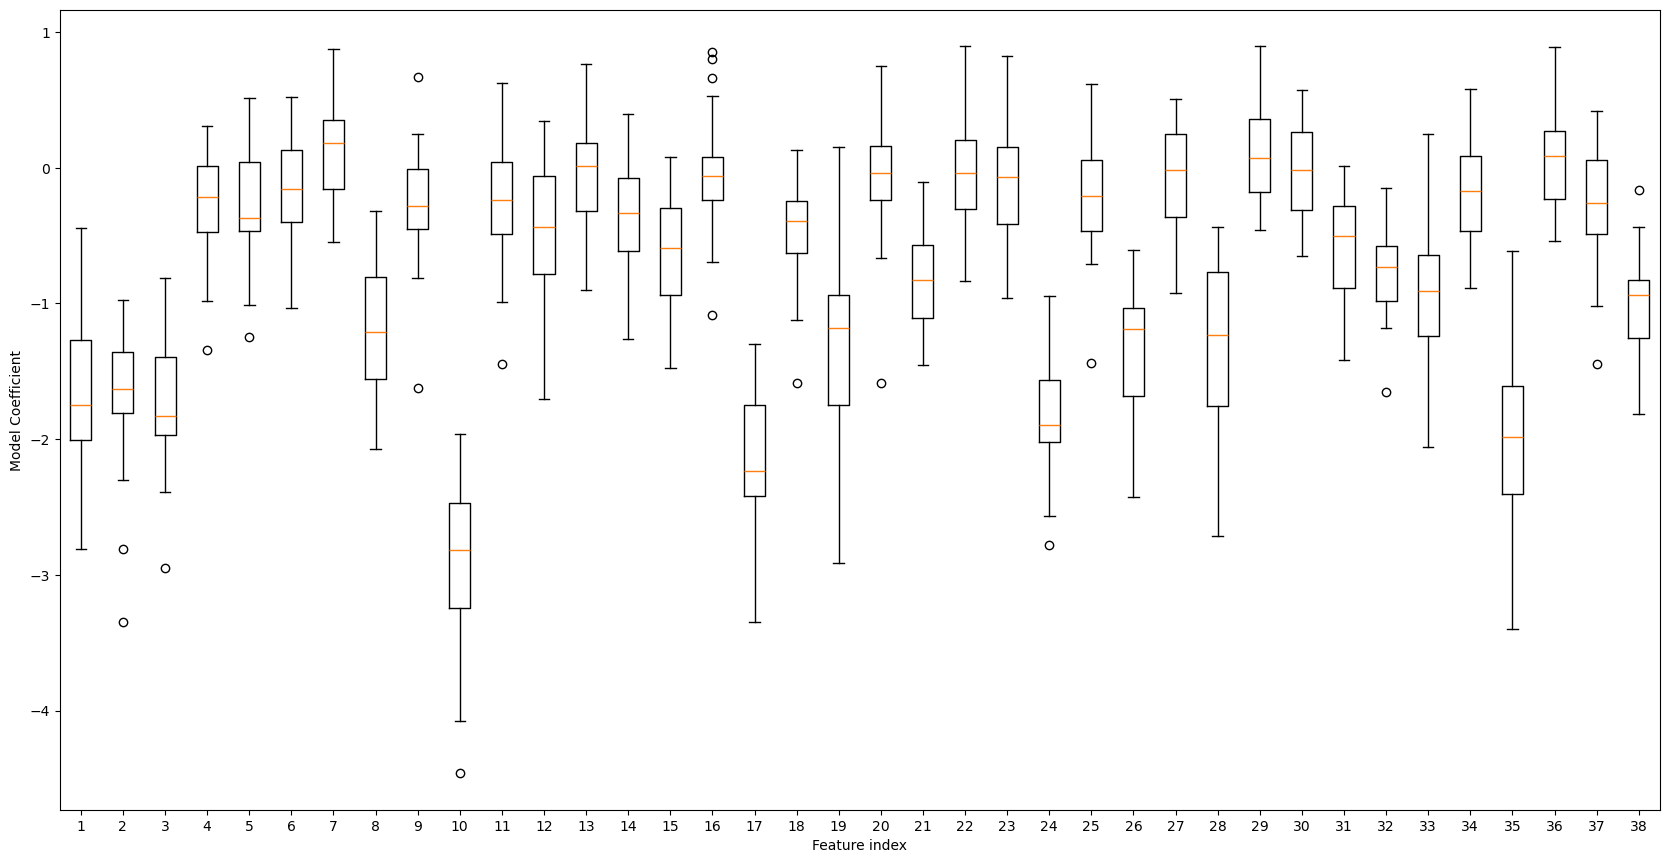

In [32]:
# Plot boxplots of the linear regression features over 30 times resampling

df_st_mdl = df_st[df_st['Model type'] == 'LinearRegression']

fig = plt.figure(figsize=(16,8))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(df_st_mdl[cols])

# show plot
plt.xlabel('Feature index')
plt.ylabel('Model Coefficient')
plt.show()

In [33]:
# determine % agreement over the 30 instances in the order of the first-k relative feature importance of Linear Regression surrogate

df_tst = df_st[['Instance nr', 'Sample nr', 'Model type', 'Best model feature importance']]
overlap = []
srted_indices = []

for i in range(len(df_tst[df_tst['Model type'] == 'LinearRegression'])):
    srtd_ind_ins = np.argsort(df_tst[df_tst['Model type'] == 'LinearRegression'].iloc[i]['Best model feature importance'])[::-1]
    srted_indices.append(srtd_ind_ins)

for i in range(1, len(srted_indices[0]) + 1):
    ovrlp = 0
    max_ovrlp = 0
    for j1 in range(len(srted_indices)):
        st1 = srted_indices[j1][:i]
        for j2 in range(j1+1, len(srted_indices)):
            st2 = srted_indices[j2][:i]
            lcl_intrsctn  = list(set(st1) & set(st2))
            ovrlp = ovrlp + len(lcl_intrsctn)
            max_ovrlp = max_ovrlp + i
    overlap.append(ovrlp/max_ovrlp)

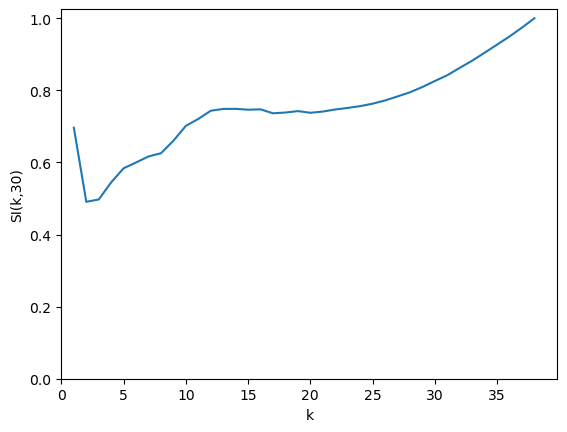

In [34]:
# plot % agreement over the 30 instances in the order of the first-k relative feature importance of Linear Regression surrogate

x = [*range(1,len(srted_indices[0]) + 1)] 
plt.plot(x, overlap) 
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('k')
plt.ylabel('SI(k,30)')
plt.show()